In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Load Hoboken Area Price
df = pd.read_csv('../pre_data/Hoboken_price.csv')

In [3]:
data = df.set_index('date')
data.index = pd.DatetimeIndex(data.index)

In [4]:
data.head()

,price
date,
2010-11-01,2534.0
2010-12-01,2553.0
2011-01-01,2553.0
2011-02-01,2539.0
2011-03-01,2525.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 2010-11-01 to 2019-01-01
Data columns (total 1 columns):
price    99 non-null float64
dtypes: float64(1)
memory usage: 1.5 KB


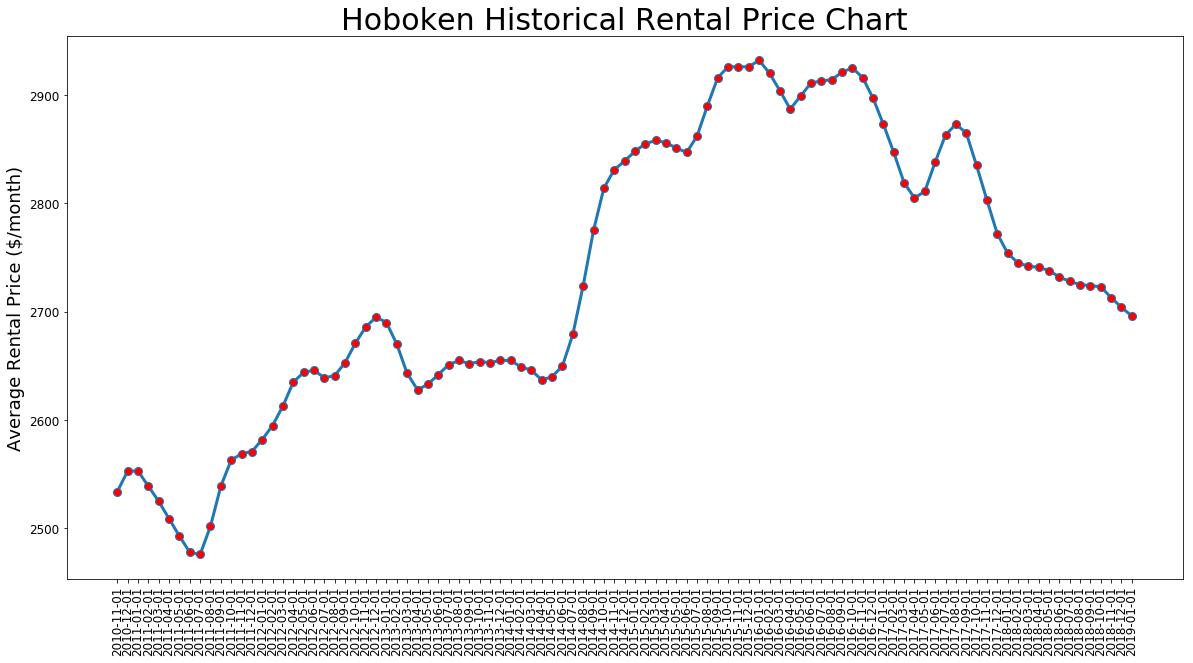

In [6]:
# Check the history data
m = df['date']
n = df['price']
plt.figure(figsize = (20, 10))
plt.plot(m, n, linewidth = 3, marker = 'o', markerfacecolor='red', markersize=8)
plt.title('Hoboken Historical Rental Price Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 90)
# for i, j in zip(m, n):
#     plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
plt.show()

## LSTM model - Long Short-Term Memory model

In [7]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# transform to supervised learning
supervised = timeseries_to_supervised(data, 1)
print(supervised.head())

             price   price
date                      
2010-11-01     0.0  2534.0
2010-12-01  2534.0  2553.0
2011-01-01  2553.0  2553.0
2011-02-01  2553.0  2539.0
2011-03-01  2539.0  2525.0


In [8]:
# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [9]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [10]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [11]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [12]:
# fit an LSTM network to training data
from keras.layers import LSTM

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.reset_states()
    return model

Using TensorFlow backend.


In [13]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [14]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

# transform data to be stationary
raw_values = data.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-20], supervised_values[-20:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
predict = lstm_model.predict(train_reshaped, batch_size=1)

Instructions for updating:
Colocations handled automatically by placer.


Month=1, Predicted=2798.675278, Expected=2838.000000
Month=2, Predicted=2833.850472, Expected=2863.000000
Month=3, Predicted=2865.758978, Expected=2873.000000
Month=4, Predicted=2877.006811, Expected=2865.000000
Month=5, Predicted=2865.683141, Expected=2835.000000
Month=6, Predicted=2829.755898, Expected=2803.000000
Month=7, Predicted=2792.937066, Expected=2772.000000
Month=8, Predicted=2758.535125, Expected=2754.000000
Month=9, Predicted=2739.057185, Expected=2745.000000
Month=10, Predicted=2730.498278, Expected=2742.000000
Month=11, Predicted=2729.130427, Expected=2741.000000
Month=12, Predicted=2730.027259, Expected=2738.000000
Month=13, Predicted=2728.251725, Expected=2732.000000
Month=14, Predicted=2722.613932, Expected=2728.000000
Month=15, Predicted=2719.097026, Expected=2725.000000
Month=16, Predicted=2716.709481, Expected=2724.000000
Month=17, Predicted=2716.572951, Expected=2723.000000
Month=18, Predicted=2716.305270, Expected=2713.000000
Month=19, Predicted=2705.316020, Expe

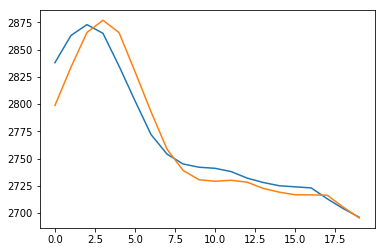

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-20:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(raw_values[-20:])
plt.plot(predictions)
plt.show()

In [16]:
# Build model

# transform data to be stationary
raw_values = data.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# transform the scale of the data
# fit scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(supervised_values)
# transform data
data_scaled = scaler.transform(supervised_values)

# fit the model
out_lstm_model = fit_lstm(data_scaled, 1, 3000, 4)

In [17]:
def prediction(step):
    result = list()
    for i in range(step):
        # make one-step forecast
        X, y = data_scaled[i, 0:-1], data_scaled[i, -1]
        yhat = forecast_lstm(out_lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, step+1-i)
        # store forecast
        result.append(yhat[0])
    return np.array(result)

In [18]:
# Get forecast 27 steps ahead in future
pred_long = prediction(step=27)
time_long = pd.date_range('20190201', periods=27, freq='MS')
pred_long_df = pd.DataFrame(np.round(pred_long,1), index = time_long, columns=['price'])
result_long = pd.concat([data, pred_long_df], axis=0)
result_long = result_long.reset_index()

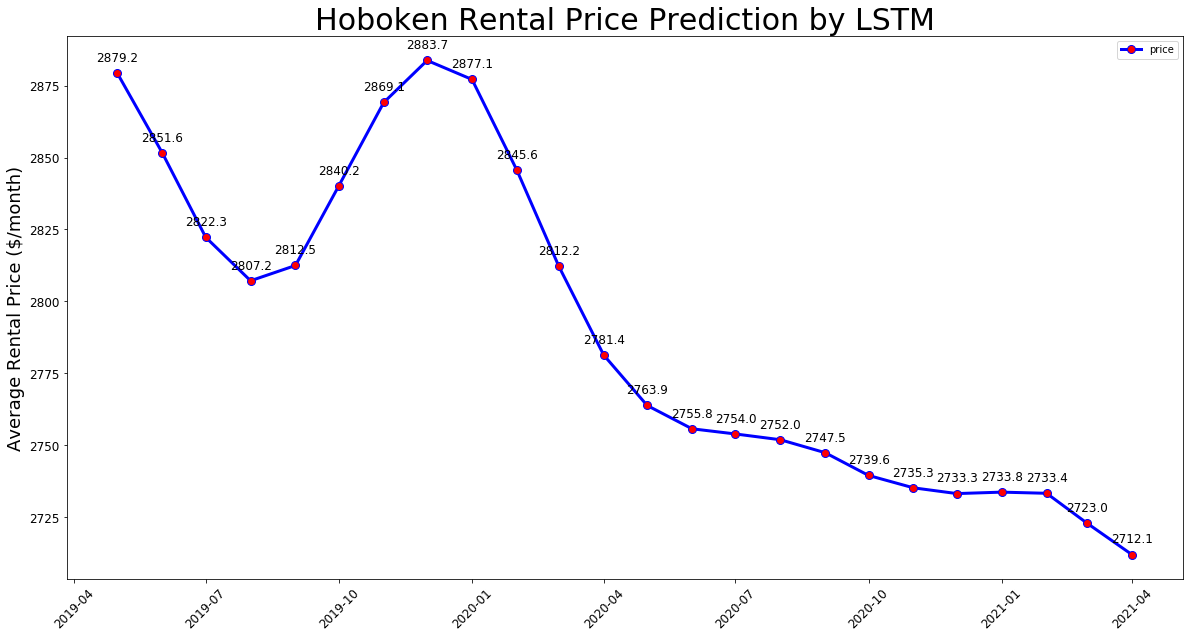

In [19]:
x2 = result_long['index'].tail(24)
y2 = result_long['price'].tail(24)

fig2 = plt.figure(figsize = (20, 10))
plt.plot(x2, y2, linewidth = 3, color='blue', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Hoboken Rental Price Prediction by LSTM', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x2, y2):
    plt.text(i, j + 3, j, ha = 'center', va = 'bottom', fontsize = 12)
    
plt.legend()
plt.show()

In [20]:
fig2.savefig("../area_predict_pics/Hoboken_long.jpg")

In [21]:
result_long.to_csv('Hoboken_result_long.csv', index=False)

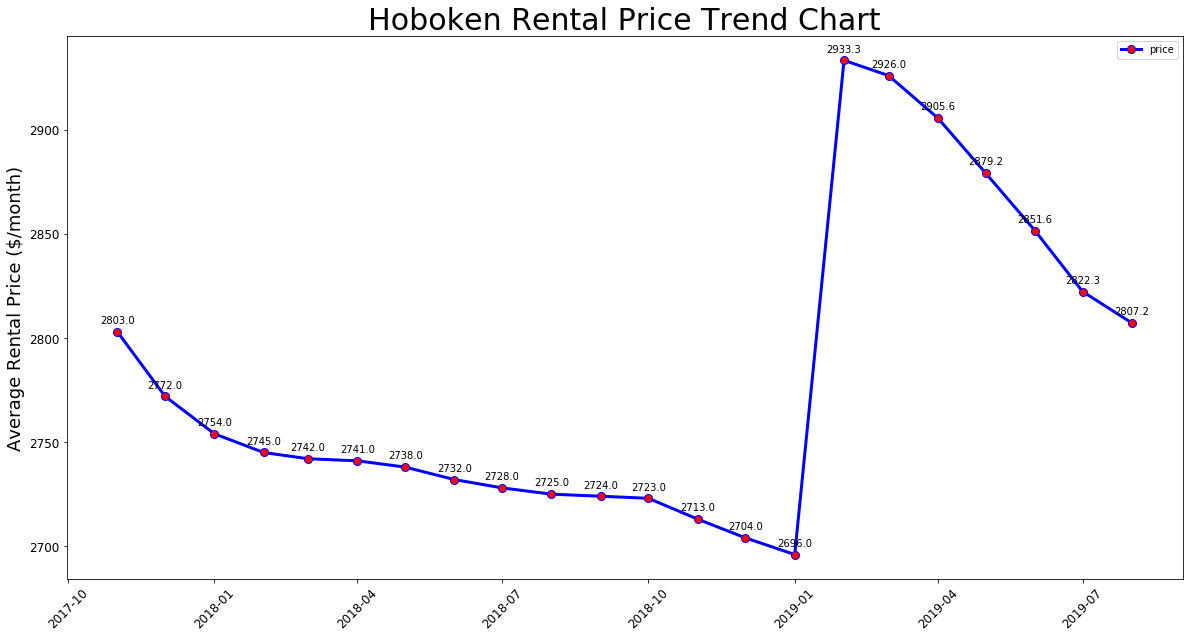

In [22]:
x = result_long['index'][-42: -20]
y = result_long['price'][-42: -20]

fig1 = plt.figure(figsize = (20, 10))
plt.plot(x, y, linewidth = 3, color='blue', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Hoboken Rental Price Trend Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x, y):
    plt.text(i, j + 3, j, ha = 'center', va = 'bottom', fontsize = 10)
    
plt.legend()
plt.show()

In [23]:
fig1.savefig("../area_predict_pics/Hoboken.jpg")

## ARIMA model - AutoRegressive Integrated Moving Average model

In [24]:
# Select the best diff (Integrated)
from statsmodels.tsa.stattools import adfuller as ADF

print(ADF(data['price']))

(-1.8704519883857313, 0.346086508425379, 10, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 588.6211908693606)


In [25]:
diff_1 = data.diff(1)
diff_1 = diff_1.dropna()
diff_1.columns = ['price_integrated']
print(ADF(diff_1['price_integrated']))

(-1.7012039439152993, 0.43049227574251736, 9, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 585.0102940942284)


In [26]:
diff_2 = diff_1.diff(1)
diff_2 = diff_2.dropna()
diff_2.columns = ['price_integrated']
print(ADF(diff_2['price_integrated']))

(-6.156992729182019, 7.327774183151908e-08, 8, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 579.136056583644)


In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox

noiseRes = acorr_ljungbox(diff_2, lags=1)
print(noiseRes)

(array([21.7257814]), array([3.14535623e-06]))


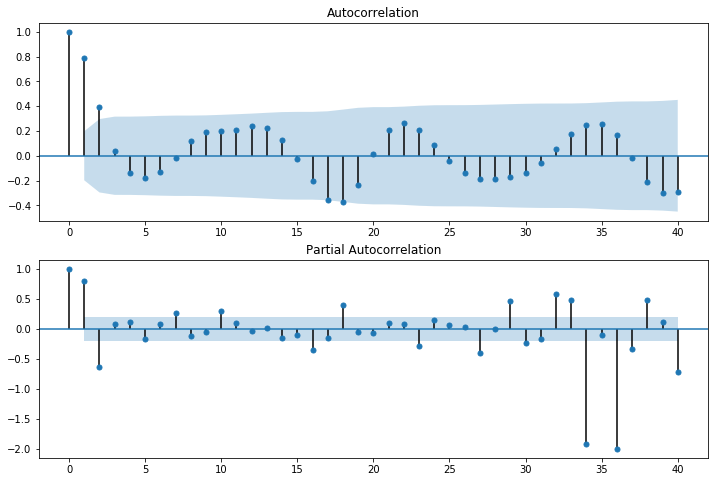

In [28]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_1,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_1,lags=40,ax=ax2)

In [29]:
# Select the best AR(p) and MA(q)
arma_mod20 = sm.tsa.ARMA(diff_1,(10,0),freq='MS').fit()
print(arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic)
arma_mod30 = sm.tsa.ARMA(diff_1,(0,1),freq='MS').fit()
print(arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic)
arma_mod40 = sm.tsa.ARMA(diff_1,(10,1),freq='MS').fit()
print(arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic)
arma_mod50 = sm.tsa.ARMA(diff_1,(9,0),freq='MS').fit()
print(arma_mod50.aic,arma_mod50.bic,arma_mod50.hqic)
arma_mod60 = sm.tsa.ARMA(diff_1,(9,1),freq='MS').fit()
print(arma_mod60.aic,arma_mod60.bic,arma_mod60.hqic)

680.8651319552646 711.8847416993115 693.4119242600588
746.9721307959649 754.7270332319765 750.1088288721634
682.8125011155853 716.4170783383028 696.4048594457789
685.6904313087476 714.1250735741239 697.1916575881422
685.6661453767747 716.6857551208216 698.2129376815689


In [30]:
p,q = 9,2

In [31]:
from statsmodels.tsa.arima_model import ARIMA

# Build ARIMA(10,2,0) model
model = ARIMA(data, (p,2,q), freq='MS')
arima_result = model.fit()

/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [32]:
# Get forecast 27 steps ahead in future
pred = arima_result.forecast(steps=27)
time = pd.date_range('20190201', periods=27, freq='MS')
pred_df = pd.DataFrame(np.round(pred[0],1), index = time, columns=['price'])
output = pd.concat([data, pred_df], axis=0)
output = output.reset_index()

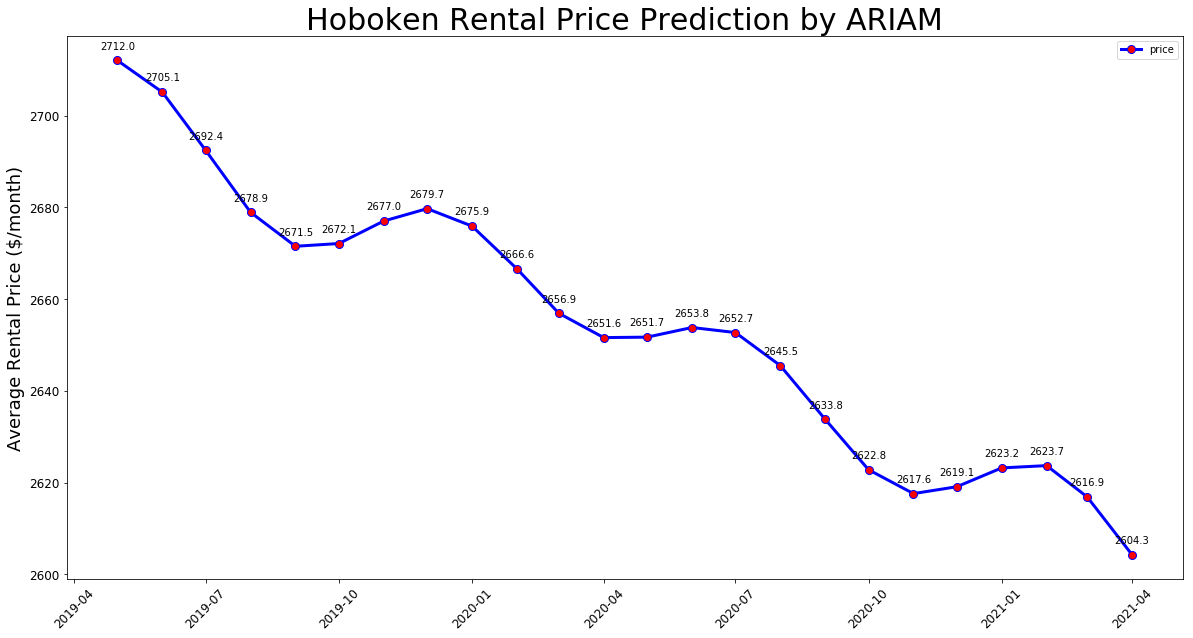

In [36]:
x3 = output['index'].tail(24)
y3 = output['price'].tail(24)

plt.figure(figsize = (20, 10))
plt.plot(x3, y3, linewidth = 3, color='blue', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Hoboken Rental Price Prediction by ARIAM', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x3, y3):
    plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
    
plt.legend()
plt.show()

In [34]:
arima_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 710.8367  
Dependent Variable: D2.price         Log-Likelihood:      -325.68   
Date:               2019-04-01 20:22 Scale:               1.0000    
No. Observations:   97               Method:              css-mle   
Df Model:           12               Sample:              01-01-2011
Df Residuals:       85                                    01-01-2019
Converged:          1.0000           S.D. of innovations: 6.652     
No. Iterations:     167.0000         HQIC:                690.900   
AIC:                677.3655                                        
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           -0.0736    0.4124   -0.1785  0.8587  -0.8819   0.7347
ar.L1.D2.price   1.5887       nan       nan     nan      nan      nan
ar.L2.D2.price  -1.5431       nan       nan     nan      nan      nan
ar.L3.D2.price   0.0602       nan       nan     nan      nan      nan
ar.L4.D2.price   0.4921    0.0404   12.1746  0.0000   0.4129   0.5713
ar.L5.D2.price  -0.5561    0.0103  -53.7739  0.0000  -0.5763  -0.5358
ar.L6.D2.price  -0.3165    0.0138  -22.9192  0.0000  -0.3435  -0.2894
ar.L7.D2.price   0.3993    0.0301   13.2472  0.0000   0.3402   0.4583
ar.L8.D2.price  -0.2951    0.0576   -5.1258  0.0000  -0.4080  -0.1823
ar.L9.D2.price  -0.1102    0.0292   -3.7706  0.0003  -0.1675  -0.0529
ma.L1.D2.price  -1.2405    0.0595  -20.8626  0.0000  -1.3571  -1.1240
ma.L2.D2.price   1.0000    0.0815   12.2728  0.0000   0.8403   1.1597
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            0.8863            -0.5891           1.0642            -0.0934
AR.2            0.8863             0.5891           1.0642             0.0934
AR.3            0.6253            -0.7805           1.0001            -0.1425
AR.4            0.6253             0.7805           1.0001             0.1425
AR.5            0.2210            -1.0668           1.0894            -0.2175
AR.6            0.2210             1.0668           1.0894             0.2175
AR.7           -1.2016            -0.6006           1.3433            -0.4262
AR.8           -1.2016             0.6006           1.3433             0.4262
AR.9           -3.7400            -0.0000           3.7400            -0.5000
MA.1            0.6203            -0.7844           1.0000            -0.1435
MA.2            0.6203             0.7844           1.0000             0.1435
====================================================================

"""